# Moro med åpne data: På Notodden er det mange luftfartøy, store fly er utenlandskeid, 2021 kan bli rekordår for nyregistreringer av fly (i en bransje som ligger nede?)

I relativt små kommuner som Notodden og Bodø finnes mange luftfartøy. Hvorfor?

Trodde du flyselskapene ligger nede, i en bransje som ikke kommer tilbake på mange år? Mange nye, store fly er nyregistrert i 2021. 

Hva er de eldste, nyeste, største og minste luftfartøyene i Norge?

Denne analysen bruker Norges luftfartøyregister som grunnlag for å se på luftfartøy i Norge.

Datakilder:
- [Norges luftfartøyregister](https://luftfartstilsynet.no/aktorer/norges-luftfartoyregister/)
- [Brings postnummertabell](https://www.bring.no/tjenester/adressetjenester/postnummer/postnummertabeller-veiledning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

** Innholdsfortegnelse **
1. [Forbered dataene](#1.-Forbered-dataene)
- [Last inn luftfartøyregisteret](#Last-inn-luftfartøyregisteret)
- [Gjøre seg kjent med dataene](#Gjøre-seg-kjent-med-dataene)
- [Slett nullverdier og fiks opp i datatyper](#Slett-nullverdier-og-fiks-opp-i-datatyper)
- [Fiks opp i produsentnavn ved å slå sammen likelydende navn](#Fiks-opp-i-produsentnavn-ved-å-slå-sammen-likelydende-navn)
- [Tilordne kommunenavn for norske eiere](#Tilordne-kommunenavn-for-norske-eiere)
- [Undersøk sammensetningen av eiere](#Undersøk-sammensetningen-av-eiere)
2. [Luftfartøy](#Luftfartøy)
- [Hva er de 5 største produsentene, målt etter antall fly og vekt?](#Hva-er-de-5-største-produsentene,-målt-etter-antall-fly-og-vekt?)
- [Hvilke år er det registrert flest fly, målt etter antall fly og vekt?](#Hvilke-år-er-det-registrert-flest-fly,-målt-etter-antall-fly-og-vekt?)
- [Hva er de eldste og nyeste, største og minste flyene i registeret?](#Hva-er-de-eldste-og-nyeste,-største-og-minste-flyene-i-registeret?)
3. [Eiere](#3.-Eiere)
- [Hvor mange eiere er norske, og hvor mange er utenlandske?](#Hvor-mange-eiere-er-norske-og-hvor-mange-er-utenlandske?)
- [Norge: Hvem eier flest luftfartøy?](#Norge:-Hvem-eier-flest-luftfartøy?)
- [Norge: Hvilke kommuner har flest registrerte luftfartøy?](#Norge:-Hvilke-kommuner-har-flest-registrerte-luftfartøy?)
4. [Forbedringsforslag til dataeier. Hvordan kan dataene gjøres mer egnet for analyse?](#4.-Forbedringsforslag-til-dataeier-for-å-gjøre-informasjonen-mer-tilgjengelig)

# 1. Forbered dataene
Det første som må gjøres, er å laste inn luftfartøyregisteret og gjøre seg kjent med dette. Deretter lages spesielle datasett (dataframes) for de neste analysene. 

## Last inn luftfartøyregisteret

In [2]:
# Les inn nyeste utgave av luftfartøyregisteret (1. juli 2021).
# Luftfartøyregisteret kan hentes herfra: 
# https://luftfartstilsynet.no/aktorer/norges-luftfartoyregister/registrerte-luftfartoy/
df = pd.read_excel('https://luftfartstilsynet.no/globalassets/dokumenter/nlr/2021/rapport-nlr-01.07.21.xls',
             skiprows=2)

## Gjøre seg kjent med dataene

In [3]:
# Litt beskrivende statistikk om datasettet. Det er totalt 1377 rader. 
# Vi ser også at flere kolonner har nullverdier. Disse må vi håndtere før vi kan gå videre.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1377 entries, 0 to 1376
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Reg. merke   1370 non-null   object        
 1   Produsent    1355 non-null   object        
 2   Flytype      1370 non-null   object        
 3   Serienummer  1370 non-null   object        
 4   Vekt         1369 non-null   object        
 5   Registrert   1370 non-null   datetime64[ns]
 6   Eiertype     1370 non-null   object        
 7   Navn         1370 non-null   object        
 8   Adresse      1317 non-null   object        
 9   Postnr       1340 non-null   object        
 10  Sted         1369 non-null   object        
 11  Land         1369 non-null   object        
dtypes: datetime64[ns](1), object(11)
memory usage: 129.2+ KB


In [4]:
# Ved å bruke .head() får vi et inntrykk av hvordan datasettet ser ut. Her ser vi at kolonnen "Vekt" er desimal.
# Siden vekten angis i kilo, skal vi konvertere denne til heltall. 

# Vi ser videre at det første registreringsmerket, LN-ABA, har fire oppføringer: Tre deleiere og én 
# kontaktperson. Dermed bør vi lage flere datasett, alt etter hvilket formål.
df.head(10)

,Reg. merke,Produsent,Flytype,Serienummer,Vekt,Registrert,Eiertype,Navn,Adresse,Postnr,Sted,Land
0,LN-ABA,"Berge, Jan Milton",RV-6,24921,"726,00",2005-06-02,Deleier,"Granviken, Bjørn",Fugleviklunden 6,1570,DILLING,Norway
1,LN-ABA,"Berge, Jan Milton",RV-6,24921,"726,00",2005-06-02,Deleier,"Paulsen, Dag Henning",Butterudveien 10,1339,VØYENENGA,Norway
2,LN-ABA,"Berge, Jan Milton",RV-6,24921,"726,00",2005-06-02,Deleier,"Thoresen, Thore Reinhardt",Brenneveien 41 A,1339,VØYENENGA,Norway
3,LN-ABA,"Berge, Jan Milton",RV-6,24921,"726,00",2005-06-02,Kontaktperson,"Berge, Jan Milton",Heggedalsveien 128,1389,HEGGEDAL,Norway
4,LN-ABC,"Kobro, Terje",RV-8,81104,"816,00",2006-10-17,Kontaktperson,"Taraldsen, Stian",Micheletsvei 20,1366,LYSAKER,Norway
5,LN-ABD,"Andersen, Atle Inge",Piel Super Emeraude CP-328,1,"701,00",2006-03-24,Kontaktperson,"Andersen, Atle Inge",Tungenesveien 45,4071,RANDABERG,Norway
6,LN-ABE,Textron Aviation Inc.,U206G,U206-04218,"1633,00",2002-06-21,Kontaktperson,"Lie, Arne Martin",Tinnesåsen 16,3675,NOTODDEN,Norway
7,LN-ABF,"Vik, Tore",RV-4,1485,"680,00",2003-09-04,Kontaktperson,"Nordgaard, Ola Olavsen",Karlsvognen 1,2315,HAMAR,Norway
8,LN-ABH,SOCATA,MS 893E,12273,"1050,00",2003-04-22,Kontaktperson,Nore Auto AS,Sentrum 34,3630,RØDBERG,Norway
9,LN-ABK,"Ditleff, Peter",Smith Aviation Daytona Cub,43,"569,00",2006-06-10,Deleier,"Hverven, Ole Erik",Glimmerveien 34,1903,GAN,Norway


## Slett nullverdier og fiks opp i datatyper

In [5]:
# Slett rader med nullverdier i reg-merke
df = df.dropna(subset=['Reg. merke'])

# Konverter vekt-kolonnen til desimaltall
df['Vekt'] = df['Vekt'].str.replace(',', '.').astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1370 entries, 0 to 1369
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Reg. merke   1370 non-null   object        
 1   Produsent    1351 non-null   object        
 2   Flytype      1370 non-null   object        
 3   Serienummer  1370 non-null   object        
 4   Vekt         1355 non-null   float64       
 5   Registrert   1370 non-null   datetime64[ns]
 6   Eiertype     1370 non-null   object        
 7   Navn         1370 non-null   object        
 8   Adresse      1317 non-null   object        
 9   Postnr       1340 non-null   object        
 10  Sted         1369 non-null   object        
 11  Land         1369 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 139.1+ KB


## Fiks opp i produsentnavn ved å slå sammen likelydende navn

Undersøk liknende produsentnavn. Det er over to hundre produsentnavn. Vi ser gjennom denne og finner 
følgende navn som likner, som i praksis er samme produsent. Disse vil vi slå sammen slik at vi kan gjøre
summeringer riktig.

- 'Aerostar Aircraft Corporation', 'Aerostar SA' -> 'Aerostar'
- 'Airbus Helicopters', 'Airbus Helicopters Deutschland GmbH', -> 'Airbus Helicopters'
- 'Boeing Company', 'The Boeing Company' -> 'Boeing' (forenkling og feil)
- 'Cessna Aircraft Company', 'Textron Aviation Inc.', -> 'Textron' (Cessna har blitt kjøpt av Textron)
- 'DE HAVILLAND AIRCRAFT OF CANADA LIMITED' -> 'De Havilland' (forenkling)
- 'Diamond Aircraft Industries GmbH', 'Diamond Aircraft Industries, Inc.', -> 'Diamond' 
- 'Grumman American', 'Grumman American Aviation Corporation' -> 'Grumman'
- 'Gulfstream Aerospace Corporation', 'Gulfstream American Aviation', 'Gulfstream American Corporation' -> 'Gulfstream'
- 'Piper Aircraft', 'Piper Aircraft, Inc.' -> 'Piper'
- 'Sikorsky',  'Sikorsky Aircraft Corporation', -> 'Sikorsky'
- 'Vickers Amrstrongs Ltd', 'Vickers Armstrongs Ltd', -> 'Vickers Armstrongs'



In [6]:
# Skriv ut hele listen av produsenter for å se nærmere på den. 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df['Produsent'].sort_values().unique().tolist())

['A.S. Yakovlev Design Bureau',
 'AQUILA Aviation by Excellence AG',
 'Aero Vodochody a.s.',
 'Aerostar Aircraft Corporation',
 'Aerostar SA',
 'Aerotechnik',
 'AgustaWestland Philadelphia Corporation (AWPC)',
 'Airbus',
 'Airbus Helicopters',
 'Airbus Helicopters Deutschland GmbH',
 'Aircraft Industries a.s.',
 'Alexander Schleicher GmbH & Co. Segelflugzeugbau',
 'Alf Karlsson',
 'Alpha Aviation Manufacturing Ltd',
 'American Champion Aircraft Corporation',
 'American General Aircraft Corporation',
 'Andersen, Atle Inge',
 'Apex Aircraft',
 'Auster Aircraft Ltd.',
 'Aviat Aircraft, Inc.',
 'Avionautica Rio S.P.A',
 'Aérospatiale',
 'Backcountry Super Cub LLC.',
 'Balony Kubicek spol. s r.o',
 'Bell Helicopter Textron',
 'Bellanca Aircraft Company',
 'Bent Jacobsen',
 'Berg, Geir',
 'Berg, Iver ',
 'Berge, Jan Milton',
 'Berger, Per Arthur',
 'Bergersen, Olav',
 'Bjølgerud, Tore',
 'Bjørnebekk, Einar Henriksen',
 'Boeing Company',
 'Bombardier Inc.',
 'Boxill, Michael Richard de Courcy

In [7]:
# Gjennomfør forenkling av produsentnavn som beskrevet over. 
# Lag først en dict som viser oversettelsene
forenklinger = {
    'Aerostar Aircraft Corporation': 'Aerostar',
    'Aerostar SA': 'Aerostar',
    'Airbus Helicopters': 'Airbus Helicopters',
    'Airbus Helicopters Deutschland GmbH': 'Airbus Helicopters',
    'Boeing Company': 'Boeing',
    'The Boeing': 'Boeing',
    'The Boeing Company': 'Boeing',
    'Cessna Aircraft Company': 'Textron',
    'Textron Aviation Inc.': 'Textron',
    'DE HAVILLAND AIRCRAFT OF CANADA LIMITED': 'De Havilland',
    'DeHavilland Aircraft Co. LTD': 'De Havilland',
    'Diamond Aircraft Industries GmbH': 'Diamond',
    'Diamond Aircraft Industries, Inc.': 'Diamond', 
    'Grumman American': 'Grumman',
    'Grumman American Aviation Corporation': 'Grumman',
    'Gulfstream Aerospace Corporation': 'Gulfstream',
    'Gulfstream American Aviation': 'Gulfstream', 
    'Gulfstream American Corporation': 'Gulfstream',
    'Piper Aircraft': 'Piper',
    'Piper Aircraft, Inc.': 'Piper',
    'Sikorsky Aircraft Corporation': 'Sikorsky',
    'Vickers Amrstrongs Ltd': 'Vickers Armstrongs',
    'Vickers Armstrongs Ltd': 'Vickers Armstrongs'
} 

# Iterer over dict'en og erstatt verdier
for key in forenklinger:
    df['Produsent'] = df['Produsent'].str.replace(key,forenklinger[key], regex=False)

In [8]:
# Inspisér den oppdaterte produsentlisten der likelydende navn er slått sammen
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df['Produsent'].sort_values().unique().tolist())

['A.S. Yakovlev Design Bureau',
 'AQUILA Aviation by Excellence AG',
 'Aero Vodochody a.s.',
 'Aerostar',
 'Aerotechnik',
 'AgustaWestland Philadelphia Corporation (AWPC)',
 'Airbus',
 'Airbus Helicopters',
 'Aircraft Industries a.s.',
 'Alexander Schleicher GmbH & Co. Segelflugzeugbau',
 'Alf Karlsson',
 'Alpha Aviation Manufacturing Ltd',
 'American Champion Aircraft Corporation',
 'American General Aircraft Corporation',
 'Andersen, Atle Inge',
 'Apex Aircraft',
 'Auster Aircraft Ltd.',
 'Aviat Aircraft, Inc.',
 'Avionautica Rio S.P.A',
 'Aérospatiale',
 'Backcountry Super Cub LLC.',
 'Balony Kubicek spol. s r.o',
 'Bell Helicopter Textron',
 'Bellanca Aircraft Company',
 'Bent Jacobsen',
 'Berg, Geir',
 'Berg, Iver ',
 'Berge, Jan Milton',
 'Berger, Per Arthur',
 'Bergersen, Olav',
 'Bjølgerud, Tore',
 'Bjørnebekk, Einar Henriksen',
 'Boeing',
 'Bombardier Inc.',
 'Boxill, Michael Richard de Courcy',
 'Brekke, Bjørn Joar',
 'Brødreskift, Knut',
 'CPAC, Inc.',
 'Cameron Balloons LTD

## Tilordne kommunenavn for norske eiere
Poenget med dette er å undersøke hvilke fylker og kommuner som har flest fly. I denne øvelsen benyttes Brings [postnummertabeller](https://www.bring.no/tjenester/adressetjenester/postnummer/postnummertabeller-veiledning).

In [9]:
# Last inn postnumre
postnr = pd.read_csv('https://www.bring.no/tjenester/adressetjenester/postnummer/postnummertabeller-veiledning/_/attachment/download/7f0186f6-cf90-4657-8b5b-70707abeb789:c592731be13e0a0588de5a345917c96afd317022/Postnummerregister-ansi.txt',
                     encoding = 'ISO-8859-1', sep='\t', header=0, index_col=False, 
                     names=['Postnummer', 'Poststed', 'Kommunenr', 'Kommune', 'Kategori'],
                     dtype={'Postnummer': str, 'Kommunenr': str} 
                     )

# Lag ny kolonne i eiere for kommune ved å slå sammen postnr og eiere. Slett deretter unødige kolonner.
df = df.merge(postnr, how='left', left_on='Postnr', right_on='Postnummer').drop(
        axis=1, labels=['Postnummer', 'Poststed', 'Kategori'])

# Sjekk at dataene ser riktig ut.
df

,Reg. merke,Produsent,Flytype,Serienummer,Vekt,Registrert,Eiertype,Navn,Adresse,Postnr,Sted,Land,Kommunenr,Kommune
0,LN-ABA,"Berge, Jan Milton",RV-6,24921,726.0,2005-06-02,Deleier,"Granviken, Bjørn",Fugleviklunden 6,1570,DILLING,Norway,3002,MOSS
1,LN-ABA,"Berge, Jan Milton",RV-6,24921,726.0,2005-06-02,Deleier,"Paulsen, Dag Henning",Butterudveien 10,1339,VØYENENGA,Norway,3024,BÆRUM
2,LN-ABA,"Berge, Jan Milton",RV-6,24921,726.0,2005-06-02,Deleier,"Thoresen, Thore Reinhardt",Brenneveien 41 A,1339,VØYENENGA,Norway,3024,BÆRUM
3,LN-ABA,"Berge, Jan Milton",RV-6,24921,726.0,2005-06-02,Kontaktperson,"Berge, Jan Milton",Heggedalsveien 128,1389,HEGGEDAL,Norway,3025,ASKER
4,LN-ABC,"Kobro, Terje",RV-8,81104,816.0,2006-10-17,Kontaktperson,"Taraldsen, Stian",Micheletsvei 20,1366,LYSAKER,Norway,3024,BÆRUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,LN-AAR,"Raustein, Morten",RV-4,1486,680.0,2012-05-04,Kontaktperson,"Raustein, Morten",Synnavika 62,7318,AGDENES,Norway,5059,ORKLAND
1366,LN-AAS,SAAB-Scania AB,91A,91-128,1000.0,2003-11-27,Deleier,"Rogde, Knut",Joavegen 188,4055,SOLA,Norway,1124,SOLA
1367,LN-AAS,SAAB-Scania AB,91A,91-128,1000.0,2003-11-27,Kontaktperson,"Magnussen, Bjørn",Sandevegen 4 A,4050,SOLA,Norway,1124,SOLA
1368,LN-AAV,"Piper, Inc.",J3C-65,11615,553.0,2006-08-23,Kontaktperson,"Engeland, Ivar",Piperhaugen 8,2651,ØSTRE GAUSDAL,Norway,3441,GAUSDAL


## Undersøk sammensetningen av eiere
Som vi ser av listen nedenfor, er mange av luftfartøyene eid av spesialselskap. For eksempel er 
Widerøes 3 jetfly eid av hhv. WF Jets 1, WF Jets 2 og WF Jets 3. Siden sammensetningen er kompleks, og det vil
være tidkrevedende å undersøke hvilke grupperinger som står bak hva, har jeg unnlatt å gjøre noe mer med denne
oversikten. Jeg velger heller å fokusere på norske eiere lengre ned, som i større grad består av privatpersoner
og små selskap. 

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df['Navn'].sort_values().unique().tolist())

['A&H Aeroklubb',
 'AAA B787 1 Limited',
 'AAA MAX 3 Limited',
 'AERO-NOR Ståle Lien',
 'ANS Munkedammen',
 'AS Solo',
 'Aalberg Holding AS',
 'Aandalen, Ernst Harald',
 'Aarhus, Espen',
 'Aarkvisla, Kenneth Oskar',
 'Aarkvisla, Mette Marianne Gaathaug',
 'Aarø, Øystein',
 'Ader, Willy Gonsiglio Horatio',
 'AerCap Ireland Capital Designated Activity Company',
 'Aerial SPV Note Issuer 2021 Limited',
 'AeroCentury Corp',
 'Aeroservice AS',
 'Agrarflug Helilift GmbH & Co. KG.',
 'Agusta 109 AS',
 'Air Traffic Offshore AS',
 'AirAdvantage AS',
 'Aircraft Invest AS',
 'Aircraft Lease AS',
 'Aircraft MSN 920166 Trust',
 'Airfix Nordic Invest Limited',
 'Airlift AS',
 'Airwing Utleie AS',
 'Akershus Ballong Club',
 'Alcam AS',
 'Alebco Corporation A/S',
 'All Transport AS',
 'Alma Holding AS',
 'Almeli, Ole Martin ',
 'Alpine Helicopter Sweden AB',
 'Amundsen, Jan Kåre',
 'Andelslaget LN-GMV',
 'Andersen, Arild',
 'Andersen, Atle Inge',
 'Andersen, Dagfinn',
 'Andersens dødsbo, Per Reidar',
 

# Luftfartøy
## Hva er de 5 største produsentene, målt etter antall fly og vekt?
Det første vi skal se på er hvilke fly det finnes flest av. Siden fly varierer i størrelse - privatfly er små og rutefly er større - skal vi se både på antallet fly og total vekt.

<Figure size 432x288 with 0 Axes>

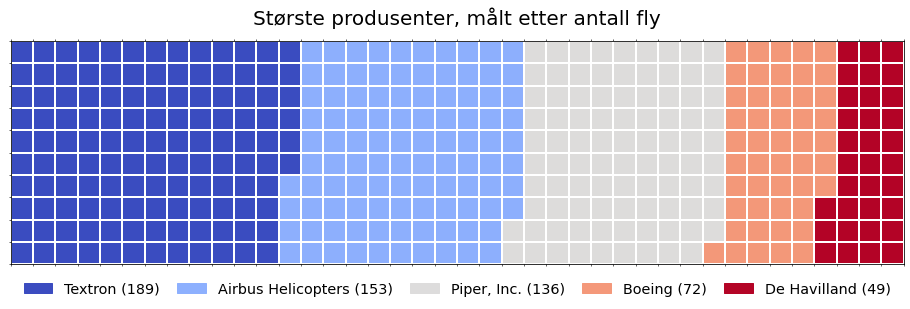

In [26]:
# Vis de fem største produsentene, etter antall med et vaffeldiagram 
# Inspirert av https://towardsdatascience.com/waffle-charts-using-pythons-matplotlib-94252689a701
# med idé til fiks fra https://stackoverflow.com/questions/56082058/legend-color-does-not-match-with-plot-color

# Lag ny dataframe der duplikater av reg. merke er slått sammen
luftfartoy = df.drop_duplicates(subset='Reg. merke')

# Lag serie med de fem største produsentene etter antall fly
produsenter_antall = luftfartoy['Produsent'].value_counts().nlargest(5)

# Funksjon for å lage vaffeldiagram. Tar ett argument: en serie. 
def vaffeldiagram(tittel, serien, filnavn = False):

    total = sum(serien)
    proportions = [(float(value) / total) for value in serien]

    width = 40
    height = 10
    total = width * height
    tiles_per_category = [round(proportion * total) for proportion in proportions]

    waffle = np.zeros((height, width))
    category_index = 0
    tile_index = 0

    for col in range(width):
        for row in range(height):
            tile_index += 1
            if tile_index > sum(tiles_per_category[0:category_index]):
                category_index += 1
            waffle[row, col] = category_index

    fig = plt.figure()
    colormap = plt.cm.coolwarm
    plt.matshow(waffle, cmap=colormap)
    ax = plt.gca()
    ax.set_xticks(np.arange(-0.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, (height), 1), minor=True)

    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])
    
    plt.title(tittel, y=1.05, fontdict={'fontsize': 20})

    values = serien
    categories = serien.index
    value_sign = ''
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
        color_val = colormap(i/(len(categories)-1))
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    plt.legend(handles=legend_handles, loc='lower center', mode='expand',
               ncol=len(categories), bbox_to_anchor=(0, -0.2, 1, 0.1), fontsize='x-large', frameon=False)
    
    if filnavn:
        plt.savefig(filnavn, bbox_inches='tight')
    

# Kall opp funksjonen med produsenter etter antall-serien
vaffeldiagram("Største produsenter, målt etter antall fly", produsenter_antall, filnavn='produsenter-antall-fly.png')

In [24]:
luftfartoy[luftfartoy['Registrert'].dt.year == 2021].sort_values(by='Vekt', ascending=False)

,Reg. merke,Produsent,Flytype,Serienummer,Vekt,Registrert,Eiertype,Navn,Adresse,Postnr,Sted,Land,Kommunenr,Kommune
283,LN-FGA,Boeing,737-82R,40014,79015.0,2021-06-10,Kontaktperson,Pembroke Aircraft Leasing 11 Limited,32 Molesworth Street,2,Dublin,Ireland,NaN,NaN
284,LN-FGB,Boeing,737-82R,40881,79015.0,2021-06-18,Kontaktperson,Pembroke Aircraft Leasing 11 Limited,32 Molesworth Street,2,Dublin,Ireland,NaN,NaN
263,LN-ENT,Boeing,737-800,42282,78999.0,2021-06-03,Kontaktperson,Shinwa Inc.,"7-8-4 Takadanobaba, Shinjuku-ku",169-0075,Tokyo,Japan,NaN,NaN
239,LN-DYK,Boeing,737-8JP,39046,78999.0,2021-06-09,Kontaktperson,UMB Bank N.A.,"6440 S. Millrock Drive, Suite 400",84121,UTAH,United States of America,NaN,NaN
240,LN-DYR,Boeing,737-8JP,40870,78999.0,2021-06-23,Kontaktperson,"Hanshin Juken Co., Ltd","1-2-14 Yoshino, Fukushima-ku, Osaka City",553-0006,Osaka,Japan,NaN,NaN
241,LN-DYX,Boeing,737-8JP,39011,78999.0,2021-06-21,Kontaktperson,KDAC Aircraft Trading 2 Limited,32 Molesworth Street,2,Dublin,Ireland,NaN,NaN
242,LN-DYY,Boeing,737-8JP,39012,78999.0,2021-06-24,Kontaktperson,KDAC Aircraft Trading 2 Limited,32 Molesworth Street,2,Dublin,Ireland,NaN,NaN
754,LN-NOD,Boeing,737-8Q8,35280,78999.0,2021-06-04,Kontaktperson,Peregrine Aviation Charlie Limited,"4450 Atlantic Avenue, Westpark",.,Shannon Co. Clare,Ireland,NaN,NaN
257,LN-ENN,Boeing,737-800,42082,78999.0,2021-04-30,Kontaktperson,Sensyo & Co. Ltd.,"3-6-17 Nishitsukiguma, Hakata-ku",812-0857,FUKUOKA,Japan,NaN,NaN
258,LN-ENO,Boeing,737-800,42088,78999.0,2021-06-16,Kontaktperson,Wilmington Trust SP Services (Dublin) Ltd,3 George`s Dock IFSC,1,DUBLIN,Ireland,NaN,NaN


<Figure size 432x288 with 0 Axes>

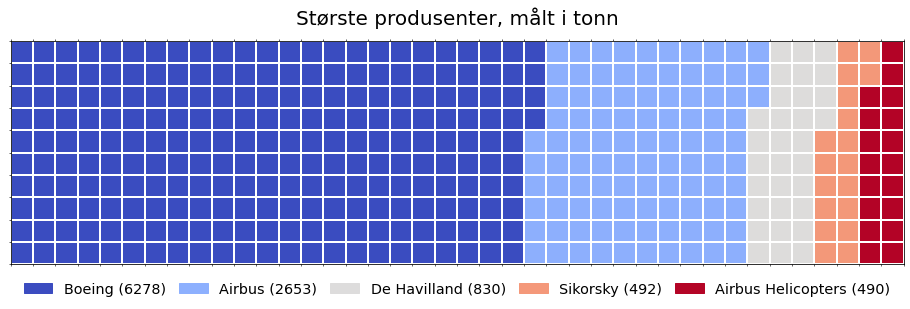

In [28]:
# Lag serie der produsenter grupperes etter vekt i tonn 
produsenter_vekt = pd.Series(luftfartoy.groupby('Produsent').apply(lambda x: x['Vekt'].sum()/1000))
                             
# Velg de fem største, målt etter vekt
produsenter_vekt = produsenter_vekt.nlargest(5).astype(int)

vaffeldiagram("Største produsenter, målt i tonn", produsenter_vekt, 'produsenter_vekt.png')

## Hvilke år er det registrert flest fly, målt etter antall fly og vekt?
De fleste flyene ble registrert i 2018.

AxesSubplot(0.125,0.125;0.775x0.755)
Registrert
2019    67
2018    64
2008    52
2020    44
2012    43
        ..
1957     1
1956     1
1960     1
1964     1
1937     1
Name: Registrert, Length: 65, dtype: int64


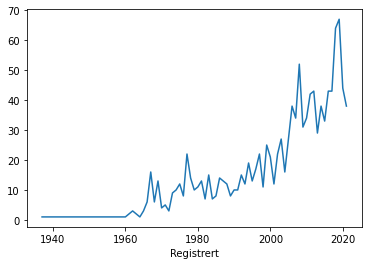

In [13]:
# Lag graf som viser antall fly registrert over registreringsår
registreringer_antall = luftfartoy.groupby(luftfartoy.Registrert.dt.year).count()['Registrert']
print(registreringer_antall.plot())
print(registreringer_antall.sort_values(ascending=False))

AxesSubplot(0.125,0.125;0.775x0.755)
Registrert
2018    1365.4050
2015    1244.2150
2021    1140.0730
2016    1139.6820
2012     819.4351
2014     723.9630
2002     655.4540
2013     617.2210
2001     576.4610
2009     378.7516
2008     360.1710
2019     316.7830
2000     316.0970
2004     276.6105
2017     245.9350
2010     245.0286
2011     210.2942
2007     202.4610
2005     161.9880
2006     161.2200
2020     130.0985
1999     123.3115
1994     119.7860
2003     111.9910
1995      87.3325
1993      80.3810
1996      71.4005
1998      46.4870
1997      26.1320
1991      15.8320
1992      12.0030
1990       8.1740
Name: Vekt, dtype: float64


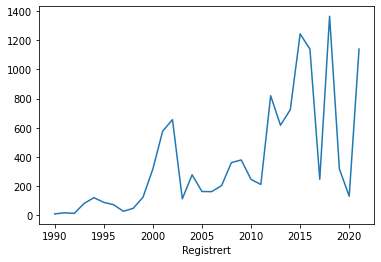

In [48]:
registreringer_vekt = luftfartoy.groupby(luftfartoy.Registrert.dt.year).sum()['Vekt']/1000
registreringer_vekt = registreringer_vekt[registreringer_vekt.index > 1989]
print(registreringer_vekt.plot())
print(registreringer_vekt.sort_values(ascending=False))

## Hva er de eldste og nyeste, største og minste flyene i registeret?

In [15]:
# Velg raden der registrert-dato er ferskest ("høyest")
luftfartoy[luftfartoy['Registrert'] == luftfartoy['Registrert'].max()]

,Reg. merke,Produsent,Flytype,Serienummer,Vekt,Registrert,Eiertype,Navn,Adresse,Postnr,Sted,Land,Kommunenr,Kommune
264,LN-ENV,Boeing,737-8JP,41140,NaN,2021-06-30,Kontaktperson,Doric NAS Limited,"Ground Floor, Dorey Court, Admiral Park",GY1 2HT,St. Peter Port,NaN,NaN,NaN
880,LN-OII,Sikorsky,S-92A,920224,NaN,2021-06-30,Kontaktperson,"Wells Fargo Trust Company, National Association","299 Main Street , 5th Floor , MAC: U1228-051,",UT 84111,SALT LAKE CITY,United States of America,NaN,NaN


In [16]:
# Velg raden der registrert-dato er eldst ("lavest")
luftfartoy[luftfartoy['Registrert'] == luftfartoy['Registrert'].min()]

,Reg. merke,Produsent,Flytype,Serienummer,Vekt,Registrert,Eiertype,Navn,Adresse,Postnr,Sted,Land,Kommunenr,Kommune
272,LN-FAB,Taylor Aircraft Corporation,J-2 Cub,980,485.0,1937-12-04,Kontaktperson,FABIAN,"c/o Stig Børrestuen, Strandbygdvegen 154",2409,ELVERUM,Norway,3420,ELVERUM


In [17]:
# Velg raden der vekt er lavest, men over 0. Noen oppføringer mangler informasjon om vekt
luftfartoy[luftfartoy['Vekt'] > 0].nsmallest(columns=['Vekt'], n=1)

,Reg. merke,Produsent,Flytype,Serienummer,Vekt,Registrert,Eiertype,Navn,Adresse,Postnr,Sted,Land,Kommunenr,Kommune
485,LN-GAA,Eiri-Avion O/Y,PIK-3B,1,232.0,1974-03-21,Kontaktperson,"Lindberg, Petter",Edvard Munchs gate 10,1511,MOSS,Norway,3002,MOSS


In [18]:
# Velg raden der vekt er høyest
luftfartoy[luftfartoy['Vekt'] == luftfartoy['Vekt'].max()]

,Reg. merke,Produsent,Flytype,Serienummer,Vekt,Registrert,Eiertype,Navn,Adresse,Postnr,Sted,Land,Kommunenr,Kommune
1122,LN-RKG,Airbus,A340-313,424,275000.0,2001-11-30,Kontaktperson,SAS Norge AS,Teknisk base 2. etasje,2060,GARDERMOEN,Norway,3033,ULLENSAKER


# 3. Eiere
## Hvor mange eiere er norske og hvor mange er utenlandske?
Definisjonen som brukes her er landet eieren er registrert i. Dersom  et selskap er registrert i
et annet land, men der det selskapet igjen er eid av en norsk enhet, vil det bli registrert som utenlandskeid.

,Andel
Norskeid,0.852555
Utenlandskeid,0.147445


<AxesSubplot:title={'center':'Norske og utenlandske eiere, antall fly'}>

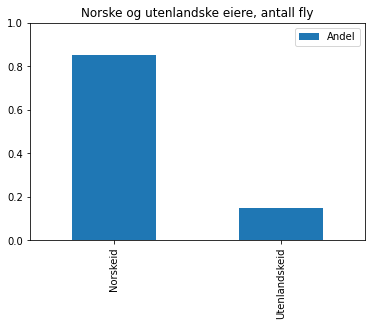

In [47]:
# Andel eiere som er norske og utenlandske
antall_norske = len(df[df['Land'] == 'Norway'])
antall_utenlandske = len(df[df['Land'] != 'Norway'])
andel_norske = antall_norske / (antall_norske + antall_utenlandske)
andel_utenlandske = antall_utenlandske / (antall_norske + antall_utenlandske)

norsk_utenlandsk_andel = pd.DataFrame(data={'Andel': [andel_norske, andel_utenlandske]},
                                index=['Norskeid', 'Utenlandskeid'])
display(norsk_utenlandsk_andel)
norsk_utenlandsk_andel.plot(kind='bar', title='Norske og utenlandske eiere, antall fly', ylim=(0, 1))

,Vekt (andel)
Norskeid,0.294382
Utenlandskeid,0.705618


<AxesSubplot:title={'center':'Norske og utenlandske eiere, vekt'}>

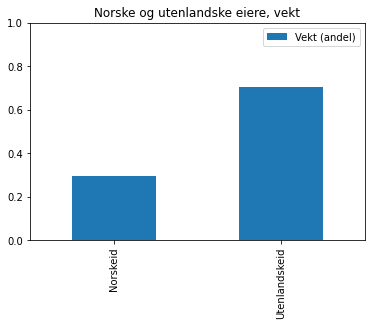

In [46]:
# Andel av vekten av flyene som er hhv. norskeid og utenlandskeid
antall_norske_kilo = df[df['Land'] == 'Norway']['Vekt'].sum()
antall_utenlandske_kilo = df[df['Land'] != 'Norway']['Vekt'].sum()
andel_norske_kilo = antall_norske_kilo / (antall_norske_kilo + antall_utenlandske_kilo)
andel_utenlandske_kilo = antall_utenlandske_kilo / (antall_norske_kilo + antall_utenlandske_kilo)

norsk_utenlandsk_vekt = pd.DataFrame(data={'Vekt (andel)': [andel_norske_kilo, andel_utenlandske_kilo]},
                                     index=['Norskeid', 'Utenlandskeid'])
display(norsk_utenlandsk_vekt)
norsk_utenlandsk_vekt.plot(kind='bar', title='Norske og utenlandske eiere, vekt', ylim=(0, 1))

## Norge: Hvem eier flest luftfartøy?
På listen nedenfor - som viser antall fly - finner vi forventede navn som Widerøe og SAS (Norwegian har valgt en annen eierskapsstrategi for sine fly, og dukker derfor ikke opp på listen her). 

Universitetet i Tromsø har en trafikkflygerutdanning, som nok er årsaken til at de eier fly.

Privatpersonen Petter Lindberg opp på listen, med sine 11 fly. Han eier blant annet det minste flyet i registeret, seilflyet LN-GAA på drøye 240 kg.

In [39]:
norske_eiere_antall = df[df['Land'] == 'Norway']

norske_eiere_antall.groupby('Navn').count()['Reg. merke'].sort_values(ascending=False)[:10]

Navn
Widerøe Asset AS                   35
Sky Management AS                  18
Skjolden Cruisekai AS              12
Nordea Finance Equipment AS        12
SAS Norge AS                       11
Lindberg, Petter                   11
Airlift AS                         11
Pegasus Helicopter AS              10
Staten v/Universitetet i Tromsø    10
Helitrans Invest AS                 8
Name: Reg. merke, dtype: int64

## Norge: Hvilke kommuner har flest registrerte luftfartøy?
Ved første øyekast er det kanskje overraskende at relativt lille Bodø kommer på 2. plass på listen. Årsaken er at Widerøes hovedkvarter ligger her. Det er også en del fly i privat eie.

Notodden, med sine 12.000 innbyggere, ligger også høyt oppe. Her finnes flyskolen Pilot Flight Academy.

In [36]:
# Hva er de største "eierkommunene", målt i antall fly?
df.groupby('Kommune')['Reg. merke'].nunique().nlargest(10)

,Reg. merke
Kommune,
OSLO,91
BODØ,48
LILLESTRØM,45
BÆRUM,40
NOTODDEN,38
SANDEFJORD,38
TRONDHEIM,34
BERGEN,29
TROMSØ,28


In [44]:
df[df.Kommune == 'NOTODDEN']

,Reg. merke,Produsent,Flytype,Serienummer,Vekt,Registrert,Eiertype,Navn,Adresse,Postnr,Sted,Land,Kommunenr,Kommune
6,LN-ABE,Textron,U206G,U206-04218,1633.0,2002-06-21,Kontaktperson,"Lie, Arne Martin",Tinnesåsen 16,3675,NOTODDEN,Norway,3808,NOTODDEN
77,LN-AOA,Vickers Armstrongs,Spitfire IX,6S-223772,NaN,2016-05-09,Kontaktperson,Spit Air AS,Merdevegen 18B,3676,NOTODDEN,Norway,3808,NOTODDEN
133,LN-BFT,"Piper, Inc.",L-4J,12641,531.0,1967-03-14,Kontaktperson,"Vassbotten, Sondre",SØNDRE VESTSIDAVEG 298,3677,NOTODDEN,Norway,3808,NOTODDEN
155,LN-BIV,SAAB-Scania AB,MFI-15-200A,15.801,1200.0,1977-02-02,Kontaktperson,"Vassbotten, Øyvind",O G Hauges veg 17,3676,NOTODDEN,Norway,3808,NOTODDEN
177,LN-BWF,Textron,180C,180-50813,1270.0,1965-02-04,Kontaktperson,"Vassbotten, Sondre",SØNDRE VESTSIDAVEG 298,3677,NOTODDEN,Norway,3808,NOTODDEN
246,LN-EFA,Textron,T206H,T20608616,1633.0,2011-03-22,Kontaktperson,Scandinavian Aircraft AS,Merdeveien 20,3676,NOTODDEN,Norway,3808,NOTODDEN
312,LN-FTT,Diamond,DA 42 NG,42.N198,1999.0,2016-02-01,Kontaktperson,Sky Management AS,Merdeveien 20,3676,NOTODDEN,Norway,3808,NOTODDEN
313,LN-FTU,Diamond,DA 40 NG,40.NC004,1310.0,2017-09-05,Kontaktperson,Sky Management AS,Merdeveien 20,3676,NOTODDEN,Norway,3808,NOTODDEN
314,LN-FTV,Diamond,DA 40 NG,40.NC005,1310.0,2017-12-22,Kontaktperson,Sky Management AS,Merdeveien 20,3676,NOTODDEN,Norway,3808,NOTODDEN
315,LN-FTW,Diamond,DA 40 NG,40.NC006,1310.0,2017-12-22,Kontaktperson,Sky Management AS,Merdeveien 20,3676,NOTODDEN,Norway,3808,NOTODDEN


# 4. Forbedringsforslag til dataeiere for å gjøre informasjonen mer tilgjengelig
Norsk luftfartøyregister er på mange måter et interessant datasett for flyinteresserte. For å gjøre det enklere å bruke datasettet for andre, kan dataeier gjøre noen små tiltak.

1. **Datatype i kolonner.**
- Kolonnnen "Vekt" inneholder informasjon om fartøyets vekt. I Excel-arket registeret kommer i, er denne kolonnen angitt som tekststreng. Dette medfører unødig ekstraarbeid i forberedelsesfasen.

2. **Manglende informasjon om vekt.**
- Noen rader inneholder ikke informasjon om fartøyets vekt.

3. **Produsentnavn inneholder duplikater.**
- Et vanlig problem i kundesystemer er at over tid endrer kunder navn, noen kunder har flere selskap de kjøper fra, mens andre ganger blir duplikater registrert ved et uhell. De samme utfordringene er i produsentnavn-kolonnen i registeret. Her er for eksempel Boeing registrert på tre måter: "The Boeing, "Boeing" og "Boeing Company". 

4. **Type luftfartøy finnes bare som sammendrag.**
- Nederst i Excel-filen står et sammendrag av hvilke typer fartøy man finner der (f.eks. "fixed-wing" og "helikopter". Denne informasjon er imidlertid ikke å finne for hvert enkelt fartøy. 

5. **Spesielle regler i datafilen som mangler dokumentasjon.**
- Noen registreringsnumre er markert med rødt i Excel-filen. Dette er tilsynelatende ikke dokumentert noe sted, og derfor vanskelig å forstå. Betyr det at registeringsnummeret er nytt? På vei ut? Annet?